# MIDRC Open-R1 Clinical Data

*Please note: This notebook uses open access data*

##### Created By: J Montgomery Maxwell

In this notebook we will visualize the distribution of subjects accross a variety demographics and their COVID-19 status in the Open-R1 dataset from The Medical Imaging and Data Resource Center. (MIDRC - https://data.midrc.org/)

The Open-R1 data set used here has 7,716 subjects, this notebook will compare the distribution of COVID-19 positive and negative patients across multiple demographic classes. In particular we will focus on the subjects' age groups (-20, 21-30, ..., 90+), sex (Male or Female), race (Black or African American, White, Asian, Pacific Islander, American Indian, Other, or Not Reported), and whether the subject is Hispanic or Latino. 

In [1]:
import gen3
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from gen3.submission import Gen3Submission
from gen3.auth import Gen3Auth
from gen3.index import Gen3Index
from gen3.query import Gen3Query
import sys, os, webbrowser

In [3]:
# Import some custom Python scripts 
home_dir = "/home/jovyan/pd"
gen3_dir = "{}/gen3".format(home_dir)
demo_dir = "{}/demos/Find_COVID_Positive_Imaging_Studies".format(home_dir)
os.system('mkdir -p {}'.format(gen3_dir))

os.system("wget https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py -O /home/jovyan/pd/gen3/expansion.py")
%run /home/jovyan/pd/gen3/expansion.py

--2022-09-19 16:06:48--  https://raw.githubusercontent.com/cgmeyer/gen3sdk-python/master/expansion/expansion.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161133 (157K) [text/plain]
Saving to: ‘/home/jovyan/pd/gen3/expansion.py’

     0K .......... .......... .......... .......... .......... 31% 47.9M 0s
    50K .......... .......... .......... .......... .......... 63% 33.5M 0s
   100K .......... .......... .......... .......... .......... 95% 44.8M 0s
   150K .......                                               100%  174M=0.004s

2022-09-19 16:06:48 (42.6 MB/s) - ‘/home/jovyan/pd/gen3/expansion.py’ saved [161133/161133]



In [4]:
api = 'https://data.midrc.org'
auth = Gen3Auth(api) # authentication class
sub = Gen3Submission(api, auth) # submission class
query = Gen3Query(auth) # query class
exp = Gen3Expansion(api,auth,sub) # class with some custom scripts
exp.get_project_ids()

Getting all project_ids you have access to in the data commons.
['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1']


/home/jovyan/pd/gen3/expansion.py:213: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df = json_normalize(res["data"]["project"])


['Open-A1', 'Open-A1_PETAL_REDCORAL', 'Open-R1']

In [5]:
def age_group(agelist):
    min_age = min(agelist)
    groups = ["-20 yr", "21-30 yr", "31-40 yr", "41-50 yr", "51-60 yr", "61-70 yr", "71-80 yr", "81-90 yr", "90+ yr"]
    grouplist = []
    for i in agelist:
        if i <= 20:
            grouplist.append(groups[0])
        elif i <= 30:
            grouplist.append(groups[1])
        elif i <= 40:
            grouplist.append(groups[2])
        elif i <= 50:
            grouplist.append(groups[3])
        elif i <= 60:
            grouplist.append(groups[4])
        elif i <= 70:
            grouplist.append(groups[5])
        elif i <= 80:
            grouplist.append(groups[6])
        elif i <= 90:
            grouplist.append(groups[7])
        else:
            grouplist.append(groups[8])
            
    return grouplist

def percent_representation(df, demographic_type, demographics):

    positive_df = df[df['covid19_positive'] == 'Yes']
    negative_df = df[df['covid19_positive'] == 'No']
    
    neg_percents = []
    pos_percents = []
    for demo in demographics:
        neg_percents.append(round(len(negative_df[negative_df[demographic_type] == demo])/len(negative_df), 4)*100)
        pos_percents.append(round(len(positive_df[positive_df[demographic_type] == demo])/len(positive_df), 4)*100)
        
    neg = pd.DataFrame()
    pos = pd.DataFrame()     
    
    neg[demographic_type] = demographics
    neg['Percent'] = neg_percents
    neg['COVID-19 Status'] = 'Negative'
    
    pos[demographic_type] = demographics
    pos['Percent'] = pos_percents
    pos['COVID-19 Status'] = 'Positive'
        
    return pd.concat([neg, pos])

In [6]:
cases = sub.export_node(program='Open',project='R1',node_type='case',fileformat='tsv')
df = pd.read_csv(StringIO(cases), sep='\t', header=0)
df['zip'] = df['zip'].astype(str)
df['age_group'] = age_group(df['age_at_index'])

df.loc[df.race == 'Native Hawaiian or other Pacific Islander', 'race'] = 'Pacific Islander'
df.loc[df.race == 'American Indian or Alaskan Native', 'race'] = 'American Indian' 
df.loc[df.race == 'Black or African American', 'race'] = 'Black or A.A.' 
df = df[['covid19_positive', 'age_group', 'sex', 'ethnicity', 'race']]
df.head()

,covid19_positive,age_group,sex,ethnicity,race
0,No,71-80 yr,Male,Not Hispanic or Latino,White
1,No,61-70 yr,Male,Not Hispanic or Latino,Not Reported
2,No,71-80 yr,Male,Not Hispanic or Latino,White
3,No,51-60 yr,Male,Not Hispanic or Latino,Black or A.A.
4,No,71-80 yr,Female,Not Hispanic or Latino,Not Reported


### Subjects' COVID-19 Status

Approximately 17% of the subjects in the Open-R1 dataset were COVID-19 positive at the time of the dataset indexing. 

In [7]:
covid_breakdown = {'Number of COVID-19 positive subjects': len(df[df['covid19_positive'] == 'Yes']['covid19_positive']), 
                   'Number of COVID-19 negative subjects': len(df[df['covid19_positive'] == 'No']['covid19_positive']), }
covid_breakdown

{'Number of COVID-19 positive subjects': 1385,
 'Number of COVID-19 negative subjects': 6331}

## Subject Distribution

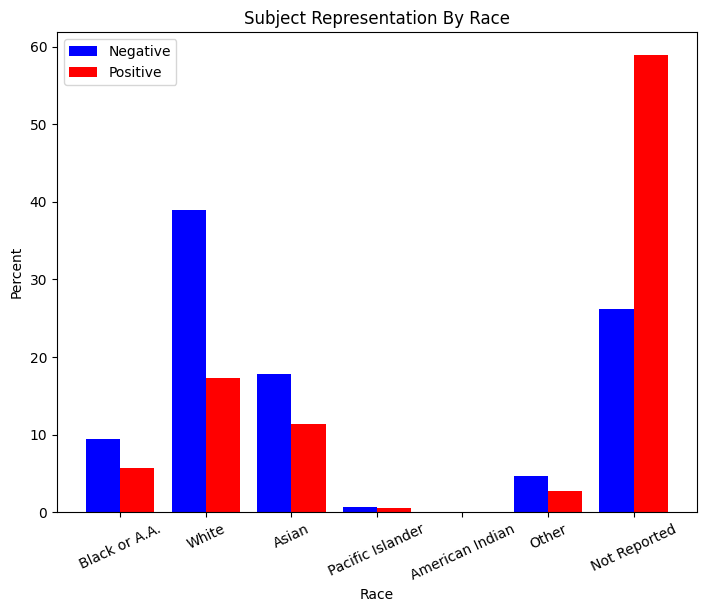

In [8]:
races = ['Black or A.A.', 
         'White', 
         'Asian', 
         'Pacific Islander', 
         'American Indian', 
         'Other', 
         'Not Reported']
plot_df = percent_representation(df, 'race', races)
X = np.arange(len(races))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(races, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Race')
ax.set_title('Subject Representation By Race')

ax.legend()
plt.show()  

Here we can see that the number of Black and African American (A.A.) subjects are nearly evenly represented amongst both COVID-19 positve and negative populations, while White and Asian subjects are significantly under represented amongst the COVID-19 positive population. Additionally the number of subjects who chose not to report their race (Not Reported) was much higher amongst the COVID-19 positive population.

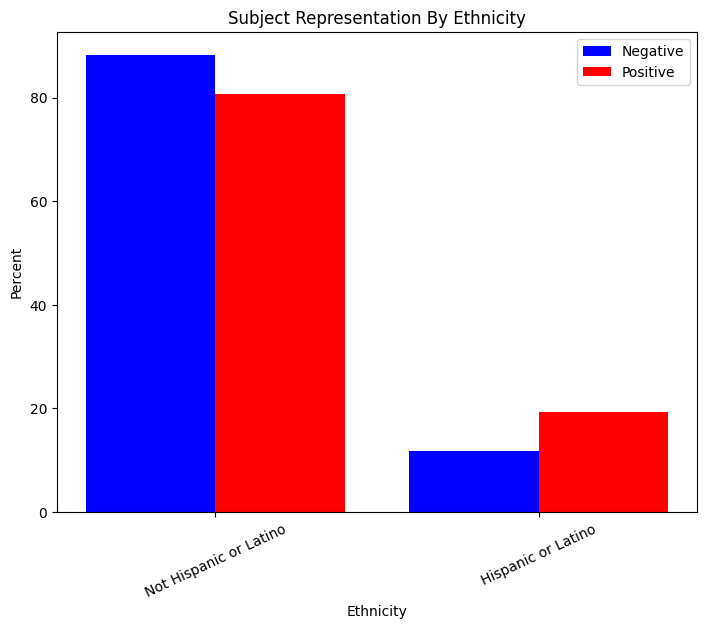

In [9]:
ethnicities = ['Not Hispanic or Latino', 'Hispanic or Latino'] 

plot_df = percent_representation(df, 'ethnicity', ethnicities)
X = np.arange(len(ethnicities))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(ethnicities, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Ethnicity')
ax.set_title('Subject Representation By Ethnicity')

ax.legend()
plt.show()  

Hispanic and Latino subjects are slightly over represented amongst COVID-19 positive population.

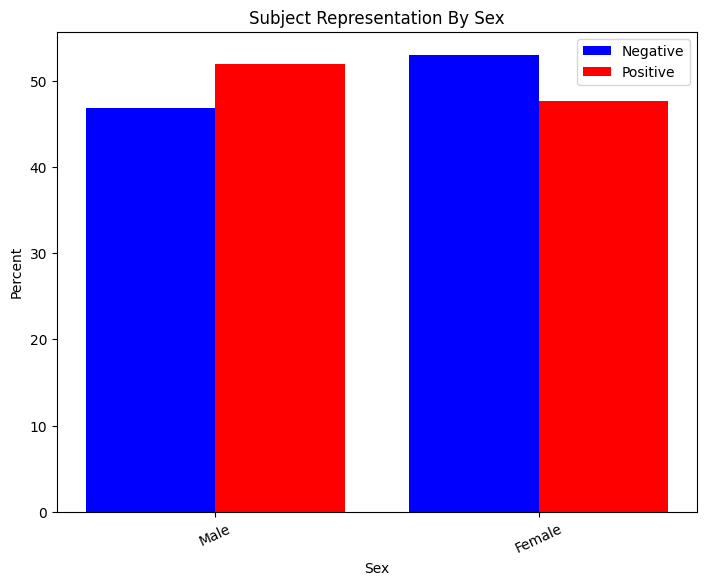

In [10]:
sexes = ['Male', 'Female'] 

plot_df = percent_representation(df, 'sex', sexes)
X = np.arange(len(sexes))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.2, plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')
ax.bar(X + 0.2, plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')

ax.set_xticks(X)
ax.set_xticklabels(sexes, rotation=25)
ax.set_ylabel('Percent')
ax.set_xlabel('Sex')
ax.set_title('Subject Representation By Sex')

ax.legend()
plt.show()  

The majority of the COVID-19 postive subjects are male and the majority of COVID-19 negative subjects are female.

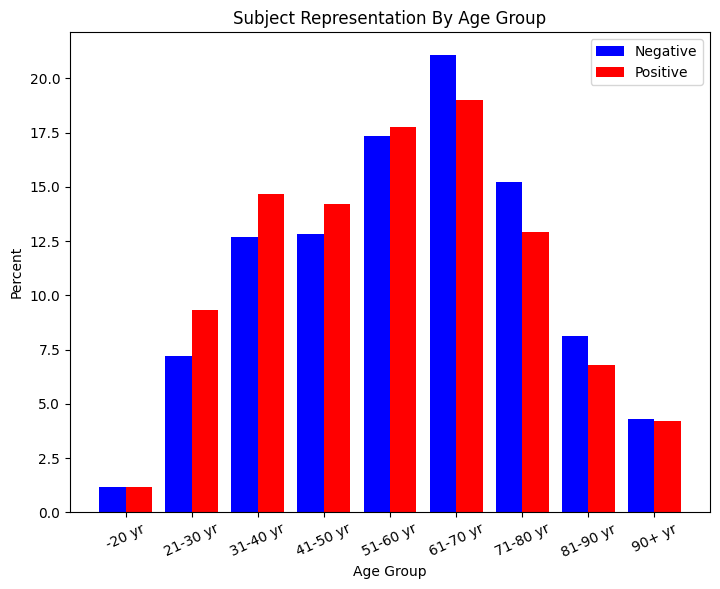

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ages = ["-20 yr", "21-30 yr", "31-40 yr", "41-50 yr", "51-60 yr", "61-70 yr", "71-80 yr", "81-90 yr", "90+ yr"]

plot_df = percent_representation(df, 'age_group', ages)
X=np.arange(9)

ax.bar(X - 0.2, 
       plot_df[plot_df['COVID-19 Status'] == 'Negative']['Percent'], color='b', width=0.4, label='Negative')

ax.bar(X + 0.2, 
       plot_df[plot_df['COVID-19 Status'] == 'Positive']['Percent'], color='r', width=0.4, label='Positive')
ax.set_xticks(X)
ax.set_xticklabels(ages, rotation=25)

ax.set_ylabel('Percent')
ax.set_xlabel('Age Group')

ax.set_title('Subject Representation By Age Group')

ax.legend()
plt.show()        

The majority of COVID-19 positive subjects are between the ages of 51 and 70, while the COVID-19 negative subjects are more evenly distributed between the 51-60, 61-70, and 71-80 age groups. The COVID-19 positive and negative subjects appear to be nearly evenly represented accross most of the age groups with the exception of the 71-80 and 81-90 year old age group which have a much higher proportion of COVID-19 negative subjects.